In [1]:
import sys
import torch
import wandb
from google.colab import drive

drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/CIFAR10_GenAI_Project/src')

Mounted at /content/drive


In [2]:
from model import VAE
from dataset import get_dataloaders
from utils import loss_function

In [ ]:
def train(config):
    wandb.init(project="cifar10-vae-final", config=config)
    cfg = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(latent_dim=cfg.latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    train_loader, test_loader = get_dataloaders(cfg.batch_size)

    model.train()

    fixed_data, _ = next(iter(test_loader))
    fixed_data = fixed_data.to(device)[:8]
    fixed_noise = torch.randn(8, cfg.latent_dim).to(device) # Keep 8 random noise vectors

    print(f"Starting Training on {device}...")

    for epoch in range(cfg.epochs):
        total_loss = 0
        total_mse = 0
        total_kld = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(data)
            loss, mse, kld = loss_function(recon, data, mu, logvar, beta=cfg.beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mse += mse.item()
            total_kld += kld.item()

        avg_loss = total_loss / len(train_loader.dataset)
        avg_mse = total_mse / len(train_loader.dataset)
        avg_kld = total_kld / len(train_loader.dataset)

        print(f"Epoch {epoch}: Loss {avg_loss:.4f} (MSE: {avg_mse:.4f}, KLD: {avg_kld:.4f})")
        wandb.log({"total_loss": avg_loss, "mse_loss": avg_mse, "kld_loss": avg_kld})

        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                recon_fixed, _, _ = model(fixed_data)

                z_projected = model.decoder_input(fixed_noise)
                z_reshaped = z_projected.view(-1, 128, 4, 4)
                generated_fixed = model.decoder(z_reshaped)

                wandb.log({
                    "Originals": [wandb.Image(img) for img in fixed_data],
                    "Reconstructions": [wandb.Image(img) for img in recon_fixed],
                    "Generated (From Noise)": [wandb.Image(img) for img in generated_fixed]
                })
            model.train()
    wandb.finish()

In [ ]:
config = {
    "project_name": "cifar10-vae-final",
    "epochs": 15,
    "batch_size": 128,
    "lr": 1e-3,
    "latent_dim": 128,
    "beta": 0.1,
    "device": "cuda"
}

if torch.cuda.is_available():
    print(f"GPU is active: {torch.cuda.get_device_name(0)}")

model = train(config)

✅ GPU is active: Tesla T4


Starting Training on cuda...
Epoch 0: Loss 66.1750 (MSE: 56.6760, KLD: 94.9903)
Epoch 1: Loss 43.3169 (MSE: 32.8445, KLD: 104.7242)
Epoch 2: Loss 39.3517 (MSE: 28.4404, KLD: 109.1124)
Epoch 3: Loss 37.5872 (MSE: 26.3518, KLD: 112.3541)
Epoch 4: Loss 36.6903 (MSE: 25.2405, KLD: 114.4982)
Epoch 5: Loss 36.1205 (MSE: 24.5385, KLD: 115.8205)
Epoch 6: Loss 35.6274 (MSE: 23.9645, KLD: 116.6294)
Epoch 7: Loss 35.2904 (MSE: 23.5494, KLD: 117.4100)
Epoch 8: Loss 35.0916 (MSE: 23.2773, KLD: 118.1424)
Epoch 9: Loss 34.7518 (MSE: 22.8769, KLD: 118.7488)
Epoch 10: Loss 34.6163 (MSE: 22.6838, KLD: 119.3246)
Epoch 11: Loss 34.4289 (MSE: 22.4499, KLD: 119.7900)
Epoch 12: Loss 34.2197 (MSE: 22.2053, KLD: 120.1444)
Epoch 13: Loss 34.1172 (MSE: 22.0838, KLD: 120.3342)
Epoch 14: Loss 33.9060 (MSE: 21.8347, KLD: 120.7124)


kld_loss,▁▄▅▆▆▇▇▇▇▇█████
mse_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
total_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
kld_loss,120.71238
mse_loss,21.83474
total_loss,33.90598


In [ ]:
def train_resnet(config):
    wandb.init(project="cifar10-vae-final", config=config)
    cfg = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNetVAE(latent_dim=cfg.latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    train_loader, test_loader = get_dataloaders(cfg.batch_size)

    model.train()

    fixed_data, _ = next(iter(test_loader))
    fixed_data = fixed_data.to(device)[:8] # Keep 8 images
    fixed_noise = torch.randn(8, cfg.latent_dim).to(device) # Keep 8 random noise vectors

    print(f"Starting Training on {device}...")

    for epoch in range(cfg.epochs):
        total_loss = 0
        total_mse = 0
        total_kld = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(data)
            loss, mse, kld = loss_function(recon, data, mu, logvar, beta=cfg.beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mse += mse.item()
            total_kld += kld.item()

        avg_loss = total_loss / len(train_loader.dataset)
        avg_mse = total_mse / len(train_loader.dataset)
        avg_kld = total_kld / len(train_loader.dataset)

        print(f"Epoch {epoch}: Loss {avg_loss:.4f} (MSE: {avg_mse:.4f}, KLD: {avg_kld:.4f})")
        wandb.log({"total_loss": avg_loss, "mse_loss": avg_mse, "kld_loss": avg_kld})

        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():

                recon_fixed, _, _ = model(fixed_data)

                z_projected = model.decoder_input(fixed_noise)
                z_reshaped = z_projected.view(-1, 256, 4, 4)
                generated_fixed = model.decoder(z_reshaped)

                wandb.log({
                    "Originals": [wandb.Image(img) for img in fixed_data],
                    "Reconstructions": [wandb.Image(img) for img in recon_fixed],
                    "Generated (From Noise)": [wandb.Image(img) for img in generated_fixed]
                })
            model.train()
    wandb.finish()

resnet training

In [5]:
from model_resnet import ResNetVAE

In [ ]:
config = {
    "project_name": "cifar10-vae-final",
    "epochs": 50,
    "batch_size": 128,
    "lr": 1e-3,
    "latent_dim": 128,
    "beta": 0.1,
    "device": "cuda"
}

if torch.cuda.is_available():
    print(f"GPU is active: {torch.cuda.get_device_name(0)}")

model = train_resnet(config)

✅ GPU is active: Tesla T4


Starting Training on cuda...
Epoch 0: Loss 63.7814 (MSE: 54.9520, KLD: 88.2935)
Epoch 1: Loss 42.2629 (MSE: 32.8457, KLD: 94.1721)
Epoch 2: Loss 38.6158 (MSE: 28.7337, KLD: 98.8212)
Epoch 3: Loss 37.1091 (MSE: 26.8644, KLD: 102.4471)
Epoch 4: Loss 36.1688 (MSE: 25.6702, KLD: 104.9863)
Epoch 5: Loss 35.5490 (MSE: 24.8533, KLD: 106.9571)
Epoch 6: Loss 35.0905 (MSE: 24.2262, KLD: 108.6426)
Epoch 7: Loss 34.7515 (MSE: 23.7610, KLD: 109.9044)
Epoch 8: Loss 34.3890 (MSE: 23.2807, KLD: 111.0830)
Epoch 9: Loss 34.0042 (MSE: 22.7832, KLD: 112.2097)
Epoch 10: Loss 33.9681 (MSE: 22.6828, KLD: 112.8536)
Epoch 11: Loss 33.7064 (MSE: 22.3620, KLD: 113.4439)
Epoch 12: Loss 33.5935 (MSE: 22.1857, KLD: 114.0781)
Epoch 13: Loss 33.2979 (MSE: 21.8479, KLD: 114.4996)
Epoch 14: Loss 33.1627 (MSE: 21.6618, KLD: 115.0096)
Epoch 15: Loss 33.0684 (MSE: 21.5072, KLD: 115.6120)
Epoch 16: Loss 32.8563 (MSE: 21.2592, KLD: 115.9714)
Epoch 17: Loss 32.7507 (MSE: 21.1095, KLD: 116.4117)
Epoch 18: Loss 32.7404 (MSE: 2

kld_loss,▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇█████████████████████████
mse_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kld_loss,119.01512
mse_loss,19.24132
total_loss,31.14283


PerceptualLoss paper

In [11]:
from utils import PerceptualLoss

In [9]:
import torch.nn as nn
def train_dfc(config):
    wandb.init(project="cifar10-vae-final", config=config, name="ResNet_DFC_Run")
    cfg = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Training with Perceptual Loss on {device}...")

    model = ResNetVAE(latent_dim=cfg.latent_dim).to(device)

    perceptual_loss_fn = PerceptualLoss().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    train_loader, test_loader = get_dataloaders(cfg.batch_size)

    fixed_data, _ = next(iter(test_loader))
    fixed_data = fixed_data.to(device)[:8]
    fixed_noise = torch.randn(8, cfg.latent_dim).to(device)

    model.train()

    for epoch in range(cfg.epochs):
        total_loss = 0
        log_mse = 0
        log_kld = 0
        log_perceptual = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(data)

            # --- Calculate Losses ---
            loss_pixel = nn.functional.mse_loss(recon, data, reduction='sum') / data.size(0)

            # 2. KL Divergence (The "Math" Loss)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / data.size(0)

            # 3. Perceptual Loss (The "Sharpness" Loss)
            # This returns a large number, so we multiply by 'alpha' to scale it down
            loss_feat = perceptual_loss_fn(recon, data)

            # --- Combine ---
            # Formula: Loss = MSE + (Beta * KLD) + (Alpha * Perceptual)
            loss = loss_pixel + (cfg.beta * loss_kld) + (cfg.alpha * loss_feat)

            loss.backward()
            optimizer.step()

            # Track metrics
            total_loss += loss.item()
            log_mse += loss_pixel.item()
            log_kld += loss_kld.item()
            log_perceptual += loss_feat.item()

        n = len(train_loader)
        avg_loss = total_loss / n
        avg_mse = log_mse / n
        avg_kld = log_kld / n
        avg_perc = log_perceptual / n

        print(f"Epoch {epoch} | Total: {avg_loss:.2f} | MSE: {avg_mse:.2f} | KLD: {avg_kld:.2f} | VGG: {avg_perc:.4f}")

        wandb.log(
            {
                "total_loss": avg_loss,
                "mse_loss": avg_mse,
                "kld_loss": avg_kld,
                "perceptual_loss": avg_perc
            }
        )

        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                recon_fixed, _, _ = model(fixed_data)

                z_projected = model.decoder_input(fixed_noise)
                z_reshaped = z_projected.view(-1, 256, 4, 4)
                generated_fixed = model.decoder(z_reshaped)

                wandb.log(
                    {
                        "Reconstructions": [wandb.Image(img) for img in recon_fixed],
                        "Generated": [wandb.Image(img) for img in generated_fixed]
                    }
                )
            model.train()

    wandb.finish()
    return model

In [10]:
config_dfc = {
    "epochs": 50,
    "batch_size": 128,
    "lr": 1e-3,
    "latent_dim": 128,
    "beta": 0.1,
    "alpha": 0.5,
}

# Run it!
print("Starting Deep Feature Consistent Training...")
model_dfc = train_dfc(config_dfc)

Starting Deep Feature Consistent Training...


🚀 Training with Perceptual Loss on cuda...
Epoch 0 | Total: 84.42 | MSE: 53.22 | KLD: 97.68 | VGG: 42.8504
Epoch 1 | Total: 59.80 | MSE: 30.96 | KLD: 110.97 | VGG: 35.4869
Epoch 2 | Total: 55.23 | MSE: 27.04 | KLD: 117.50 | VGG: 32.8793
Epoch 3 | Total: 52.97 | MSE: 25.04 | KLD: 122.40 | VGG: 31.3763
Epoch 4 | Total: 51.68 | MSE: 23.87 | KLD: 126.23 | VGG: 30.3597
Epoch 5 | Total: 50.72 | MSE: 23.01 | KLD: 129.46 | VGG: 29.5284
Epoch 6 | Total: 49.94 | MSE: 22.30 | KLD: 131.88 | VGG: 28.9059
Epoch 7 | Total: 49.50 | MSE: 21.93 | KLD: 133.53 | VGG: 28.4336
Epoch 8 | Total: 48.79 | MSE: 21.33 | KLD: 134.85 | VGG: 27.9565
Epoch 9 | Total: 48.54 | MSE: 21.11 | KLD: 136.15 | VGG: 27.6324
Epoch 10 | Total: 48.12 | MSE: 20.75 | KLD: 137.37 | VGG: 27.2782
Epoch 11 | Total: 47.73 | MSE: 20.39 | KLD: 138.57 | VGG: 26.9666
Epoch 12 | Total: 47.49 | MSE: 20.19 | KLD: 139.42 | VGG: 26.7137
Epoch 13 | Total: 47.31 | MSE: 20.06 | KLD: 140.01 | VGG: 26.4991
Epoch 14 | Total: 46.98 | MSE: 19.79 | KLD: 

kld_loss,▁▃▄▅▅▆▇▇▇▇▇█████████████████████████████
mse_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perceptual_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kld_loss,143.25986
mse_loss,17.75494
perceptual_loss,23.82266
total_loss,43.99226


In [12]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 66.1 MB/s eta 0:00:00


In [13]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as transforms

def calculate_fid(model, loader, num_batches=10, device='cuda'):
    """
    Calculates FID Score for both Reconstruction and Generation.
    """
    model.eval()

    fid = FrechetInceptionDistance(feature=2048).to(device)

    with torch.no_grad():
        for i, (real_images, _) in enumerate(loader):
            if i >= num_batches: break

            real_images = real_images.to(device)

            real_uint8 = (real_images * 255).byte()

            fid.update(real_uint8, real=True)

            if hasattr(model, '_vq_vae'):
                _, recon_images, _ = model(real_images)
            elif hasattr(model, 'reparameterize'):
                recon_images, _, _ = model(real_images)
            else:
                _, recon_images, _ = model(real_images)

            recon_images = torch.clamp(recon_images, 0, 1)
            recon_uint8 = (recon_images * 255).byte()

            fid.update(recon_uint8, real=False)

    fid_score = fid.compute()
    print(f"FID Score (Reconstruction Quality): {fid_score.item():.2f}")
    return fid_score.item()

_, test_loader = get_dataloaders(batch_size=32)

score = calculate_fid(model_dfc, test_loader, num_batches=20)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 34.6MB/s]


📉 Calculating FID on cuda (using 20 batches)...
✅ FID Score (Reconstruction Quality): 107.88


Extracting latent vectors...
Generating class archetypes...


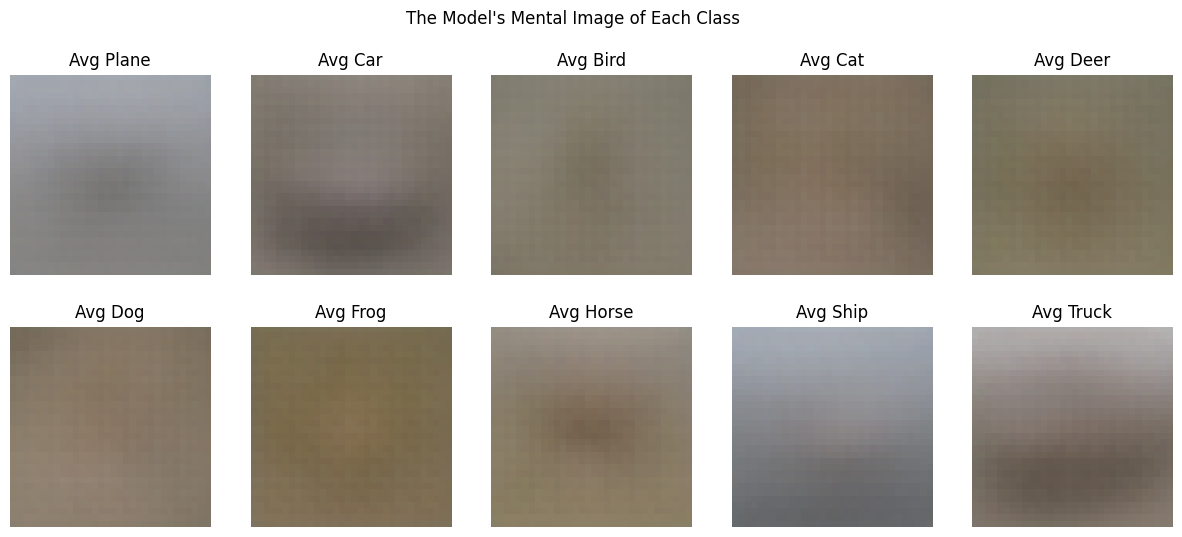

In [ ]:
import matplotlib.pyplot as plt

def visualize_class_averages(model, loader):
    model.eval()
    device = next(model.parameters()).device

    class_z = {i: [] for i in range(10)}
    class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    print("Extracting latent vectors...")
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            _, mu, _ = model(data)

            for z, label in zip(mu, labels):
                class_z[label.item()].append(z.cpu())

            if len(class_z[0]) > 100: break
    print("Generating class archetypes...")
    plt.figure(figsize=(15, 6))

    for i in range(10):
        # Average all z vectors for this class
        z_stack = torch.stack(class_z[i])
        z_mean = torch.mean(z_stack, dim=0).unsqueeze(0).to(device)

        # Decode the average
        # ResNet reshape fix:
        z_proj = model.decoder_input(z_mean)
        # CHECK YOUR MODEL: Use 256 if ResNet, 128 if Simple
        z_reshaped = z_proj.view(-1, 256, 4, 4)
        decoded_img = model.decoder(z_reshaped)

        # Plot
        plt.subplot(2, 5, i+1)
        plt.imshow(decoded_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()) # Added .detach()
        plt.title(f"Avg {class_names[i]}")
        plt.axis('off')

    plt.suptitle("The Model's Mental Image of Each Class")
    plt.show()

_, test_loader = get_dataloaders(batch_size=128)
visualize_class_averages(model_dfc, test_loader)

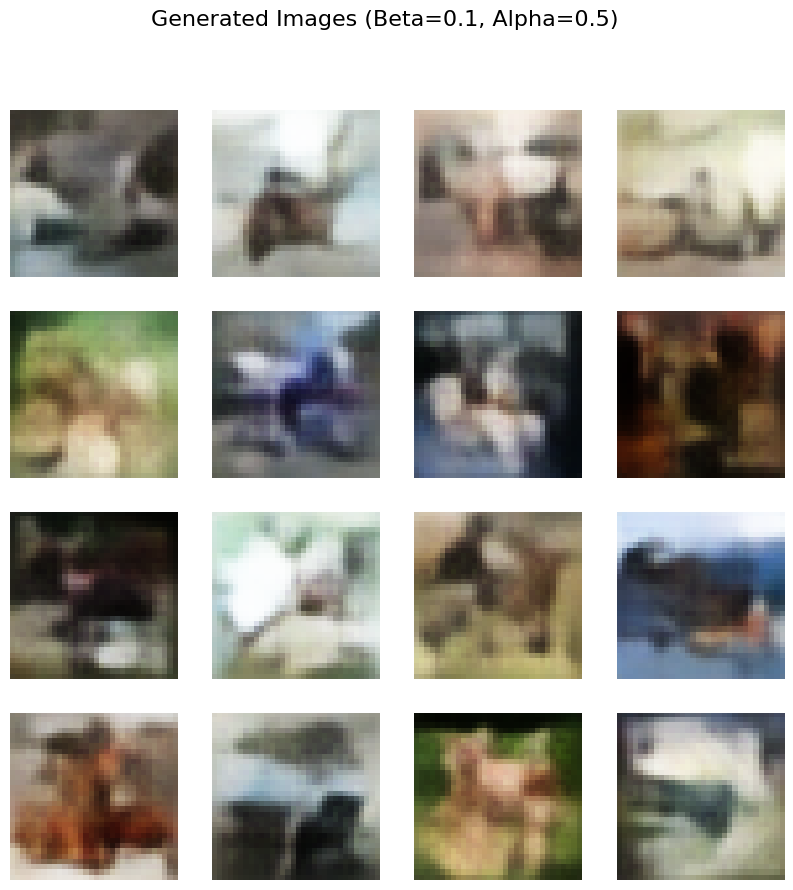

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_results(model, num_samples=16):
    model.eval()
    device = next(model.parameters()).device

    # --- 1. GENERATION (Dreaming from Noise) ---
    # Sample random noise from the "Latent Space"
    z = torch.randn(num_samples, model.latent_dim).to(device)

    with torch.no_grad():
        # Project noise to the bottleneck size
        z_projected = model.decoder_input(z)

        z_reshaped = z_projected.view(-1, 256, 4, 4)

        # Decode
        generated_imgs = model.decoder(z_reshaped)

    # Plot Generation
    generated_imgs = generated_imgs.cpu().permute(0, 2, 3, 1).numpy()

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_imgs[i])
        plt.axis('off')
    plt.suptitle(f"Generated Images (Beta={config_dfc['beta']}, Alpha={config_dfc['alpha']})", fontsize=16)
    plt.show()

visualize_results(model_dfc)

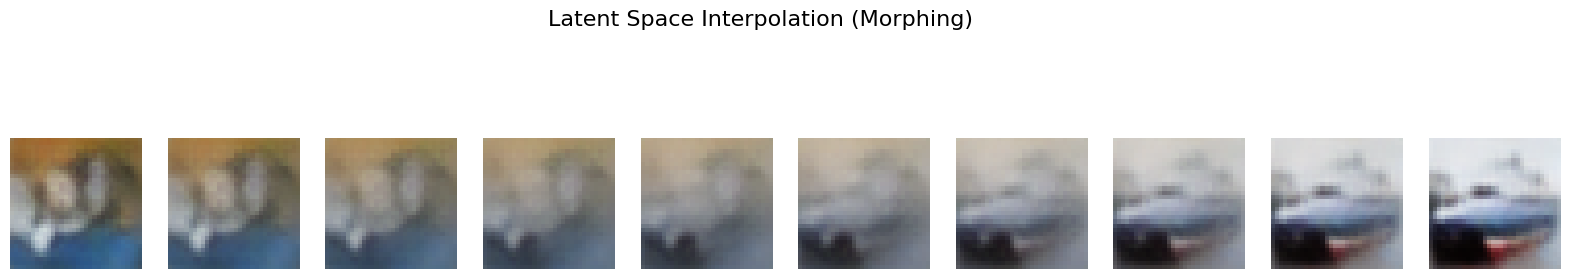

In [ ]:
import matplotlib.pyplot as plt
import torch

def interpolate_points(model, p1, p2, n_steps=10):
    model.eval()
    device = next(model.parameters()).device

    # Create interpolation vectors
    # z = (1-alpha) * p1 + alpha * p2
    alphas = torch.linspace(0, 1, n_steps).to(device)

    # We need to reshape p1 and p2 to match broadcasting
    # p1: [1, 128], alphas: [10] -> result: [10, 128]
    z_interp = p1 * (1 - alphas[:, None]) + p2 * alphas[:, None]

    with torch.no_grad():
        z_proj = model.decoder_input(z_interp)
        z_reshaped = z_proj.view(-1, 256, 4, 4) # ResNet Reshape
        decoded = model.decoder(z_reshaped)

    return decoded

# Get two real images to morph between
_, test_loader = get_dataloaders(batch_size=8)
data, _ = next(iter(test_loader))
data = data.to(next(model_dfc.parameters()).device)

# Get their latent vectors
with torch.no_grad():
    _, mu, _ = model_dfc(data)
    z1 = mu[0:1] # First image latent
    z2 = mu[1:2] # Second image latent

# Morph
morph_imgs = interpolate_points(model_dfc, z1, z2)

# Plot
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(morph_imgs[i].cpu().permute(1, 2, 0).squeeze().numpy())
    plt.axis('off')
plt.suptitle("Latent Space Interpolation (Morphing)", fontsize=16)
plt.show()

VQVAE training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model_vqvae import VQVAE

def train_vqvae(config):
    wandb.init(project="cifar10-vae-final", config=config, name="VQ-VAE_Run")
    cfg = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training VQ-VAE on {device}...")

    model = VQVAE(num_hiddens=128,
                  num_residual_layers=2,
                  num_residual_hiddens=32,
                  num_embeddings=512,
                  embedding_dim=64,
                  commitment_cost=0.25).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, amsgrad=True)

    train_loader, test_loader = get_dataloaders(cfg.batch_size)

    fixed_data, _ = next(iter(test_loader))
    fixed_data = fixed_data.to(device)[:8]

    model.train()
    data_variance = 0.0630

    for epoch in range(cfg.epochs):
        total_loss = 0
        recon_error = 0
        vq_error = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward
            # vq_loss is the cost of snapping vectors to codebook
            vq_loss, data_recon, _ = model(data)

            # Reconstruction Loss
            recon_loss = F.mse_loss(data_recon, data) / data_variance

            loss = recon_loss + vq_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            recon_error += recon_loss.item()
            vq_error += vq_loss.item()

        avg_loss = total_loss / len(train_loader)
        avg_recon = recon_error / len(train_loader)
        avg_vq = vq_error / len(train_loader)

        print(f"Epoch {epoch}: Loss {avg_loss:.4f} | Recon: {avg_recon:.4f} | VQ: {avg_vq:.4f}")

        wandb.log({
            "total_loss": avg_loss,
            "recon_loss": avg_recon,
            "vq_loss": avg_vq
        })

        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                _, recon_fixed, _ = model(fixed_data)

                wandb.log({
                    "Originals": [wandb.Image(img) for img in fixed_data],
                    "Reconstructions": [wandb.Image(img) for img in recon_fixed],
                })
            model.train()

    wandb.finish()
    return model

In [ ]:
config_vq = {
    "epochs": 50,
    "batch_size": 128,
    "lr": 1e-3,
    "model_type": "VQ-VAE"
}

model_vq = train_vqvae(config_vq)

recon_loss,█▃▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
vq_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon_loss,0.16335
total_loss,0.24216
vq_loss,0.07881


💎 Training VQ-VAE on cuda...
Epoch 0: Loss 639.6246 | Recon: 0.9774 | VQ: 638.6472
Epoch 1: Loss 26.4283 | Recon: 0.4887 | VQ: 25.9396
Epoch 2: Loss 1.1500 | Recon: 0.3181 | VQ: 0.8318
Epoch 3: Loss 0.3328 | Recon: 0.2196 | VQ: 0.1132
Epoch 4: Loss 0.2301 | Recon: 0.1912 | VQ: 0.0389
Epoch 5: Loss 0.2028 | Recon: 0.1759 | VQ: 0.0269
Epoch 6: Loss 0.1870 | Recon: 0.1653 | VQ: 0.0216
Epoch 7: Loss 0.1766 | Recon: 0.1580 | VQ: 0.0185
Epoch 8: Loss 0.1706 | Recon: 0.1530 | VQ: 0.0175
Epoch 9: Loss 0.1625 | Recon: 0.1448 | VQ: 0.0176
Epoch 10: Loss 0.1461 | Recon: 0.1261 | VQ: 0.0200
Epoch 11: Loss 0.1342 | Recon: 0.1132 | VQ: 0.0210
Epoch 12: Loss 0.1293 | Recon: 0.1087 | VQ: 0.0206
Epoch 13: Loss 0.1264 | Recon: 0.1062 | VQ: 0.0202
Epoch 14: Loss 0.1235 | Recon: 0.1041 | VQ: 0.0194
Epoch 15: Loss 0.1212 | Recon: 0.1026 | VQ: 0.0186
Epoch 16: Loss 0.1192 | Recon: 0.1013 | VQ: 0.0178
Epoch 17: Loss 0.1174 | Recon: 0.1003 | VQ: 0.0170
Epoch 18: Loss 0.1157 | Recon: 0.0993 | VQ: 0.0164
Epoch 

recon_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
vq_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon_loss,0.08324
total_loss,0.10505
vq_loss,0.02181
